## 教師あり学習でLQRエージェントを再現する

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import selfDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")
clip = 10.
env.max_torque, max_torque = clip, clip
env.action_space.high, env.action_space.low = max_torque, -max_torque
control_interval = 5

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [12]:
def gain(dt=None):
    m, l, g = env.m, env.l, env.g

    A = np.array([[0, 1], [(3*g)/(2*l), 0]])
    B = np.array([[0], [3/(m*l**2)]])
    Q = np.array([[1, 0], [0, 0.1]])
    R = np.array([[0.001]])
    
    if dt is not None:
        Ad, Bd = discretized_system(A, B, dt)  
        K = dlqr(Ad,Bd,Q,R)[0]
    else:
        K = lqr(A,B,Q,R)[0]
    
    return K

def model(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(2, activation="self_trigger_output")(x)
    model = Model(inputs=action_input, outputs=x)
    return model

In [13]:
NN = model((2,),(2,))

In [5]:
# 学習データの用意
tau = 0.001
action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
dt = tau / action_repetition
print(dt)
K = gain(dt)
x_train = []
y_train = []
for i in range(30000):
    x_train.append([np.random.randn(2,) / 16.])
    y_train.append([np.dot(K, x_train[-1][0]), tau])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape, y_train.shape)

0.001
(30000, 1, 2) (30000, 2)


In [6]:
# learn
NN.compile(loss='mean_squared_error',optimizer='adam')
history = NN.fit(x_train, y_train, batch_size=128, epochs=150, verbose=0)

In [7]:
# save
NN.save_weights('./saved_agent/self_trigger.h5')

## 学習したNNを, actorにloadする

In [19]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(2, activation="self_trigger_output")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [20]:
# loading
a = agent((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
a.actor.load_weights('./saved_agent/self_trigger.h5')

NN: -0.9385150074958801, opt: -0.897856173167959
NN: 1.4399139881134033, opt: 1.4354054864994616
NN: -2.536073684692383, opt: -2.5245612837221003
NN: -0.7503387331962585, opt: -0.7220138849520281
NN: -0.18426068127155304, opt: -0.1586913261833347
NN: 0.8607828617095947, opt: 0.856643746542701
NN: 1.1537144184112549, opt: 1.1589820170774128
NN: -1.4202280044555664, opt: -1.3767971680483384
NN: -2.2705137729644775, opt: -2.2502968489382518
NN: 3.0157699584960938, opt: 3.07543075805914
NN: 3.7156167030334473, opt: 3.81772932260003
NN: 0.63728928565979, opt: 0.6377675477150986
NN: -1.4984023571014404, opt: -1.4616552685007305
NN: -3.379920721054077, opt: -3.427483642078539
NN: 1.695428490638733, opt: 1.6935376521724093
NN: 1.4408724308013916, opt: 1.4354515845161793
NN: 2.1703503131866455, opt: 2.177942771026146
NN: 1.4372764825820923, opt: 1.4390758915754023
NN: -1.5179076194763184, opt: -1.4795119233634966
NN: 3.9006659984588623, opt: 3.9769441427841397
NN: -0.4139694273471832, opt: -0.3

NN: 1.7068893909454346, opt: 1.6986446518390652
NN: -2.5691356658935547, opt: -2.5575367683934513
NN: 1.7268317937850952, opt: 1.732098442440864
NN: -0.8368357419967651, opt: -0.806013660292013
NN: -1.3390836715698242, opt: -1.3013716571415337
NN: -0.33500707149505615, opt: -0.31785367755694605
NN: -5.881929397583008, opt: -5.82659144764456
NN: 0.8224585056304932, opt: 0.8270918228027073
NN: -0.4963335394859314, opt: -0.47205211894950516
NN: 1.1835919618606567, opt: 1.1799346068218146
NN: -2.598266124725342, opt: -2.586914525223517
NN: 1.4409738779067993, opt: 1.4368073013314264
NN: 2.4865164756774902, opt: 2.516741281049651
NN: 0.0017104296712204814, opt: 0.00803923433247511
NN: -0.8943247199058533, opt: -0.8620447967438261
NN: -0.6368473172187805, opt: -0.6066105708458704
NN: -2.6588406562805176, opt: -2.645644388157766
NN: -3.591810464859009, opt: -3.6689084339809375
NN: 1.104343056678772, opt: 1.1022653536296763
NN: -1.6980677843093872, opt: -1.6601539821763402
NN: -0.1191561669111

NN: -4.343533515930176, opt: -4.352434537370561
NN: -1.5686976909637451, opt: -1.5288894438822727
NN: 0.8360328674316406, opt: 0.838613710155284
NN: -0.5170602798461914, opt: -0.49270674895885824
NN: 1.6282821893692017, opt: 1.625429524209991
NN: -3.0310726165771484, opt: -3.047206748141673
NN: -1.748719334602356, opt: -1.711830645005054
NN: 3.1077990531921387, opt: 3.1620872810699625
NN: 2.2229275703430176, opt: 2.232826450056384
NN: 0.1719110906124115, opt: 0.1817493274652049
NN: -0.1966896951198578, opt: -0.17290518162667629
NN: 0.4951097071170807, opt: 0.5039709124751105
NN: -4.539191722869873, opt: -4.523411045661925
NN: -1.00044584274292, opt: -0.9670368857401513
NN: -0.9762037992477417, opt: -0.9455672477980863
NN: 0.4131869077682495, opt: 0.42501034527551407
NN: 2.5010087490081787, opt: 2.5190506623887106
NN: 1.0805864334106445, opt: 1.078899143886046
NN: -3.7207067012786865, opt: -3.806487204017656
NN: -3.4699225425720215, opt: -3.5316559071376905
NN: -0.22875136137008667, opt

NN: -0.7879587411880493, opt: -0.7500295214228649
NN: -0.9535521268844604, opt: -0.9230222140121824
NN: -3.003080129623413, opt: -3.0163603125199168
NN: -2.56984281539917, opt: -2.554352359039644
NN: 1.4420244693756104, opt: 1.4390272365536516
NN: -8.014522552490234, opt: -8.868590205828744
NN: -3.0388755798339844, opt: -3.051710131684928
NN: 3.4728169441223145, opt: 3.567617752358535
NN: 0.2516877055168152, opt: 0.26013155985660996
NN: 0.3718525171279907, opt: 0.3785026416539963
NN: -0.3621938228607178, opt: -0.34096107015190896
NN: -0.1387944221496582, opt: -0.11800249388690726
NN: -1.957619071006775, opt: -1.9231309784692598
NN: 2.029557704925537, opt: 2.0308828115588002
NN: 0.6036935448646545, opt: 0.6053211618176857
NN: 5.1241455078125, opt: 5.102764651226754
NN: 1.9286166429519653, opt: 1.9244140347348127
NN: -3.136732816696167, opt: -3.166664449912033
NN: 1.9704766273498535, opt: 1.9664709099472448
NN: 0.49930936098098755, opt: 0.5036629335007001
NN: 1.245694637298584, opt: 1.24

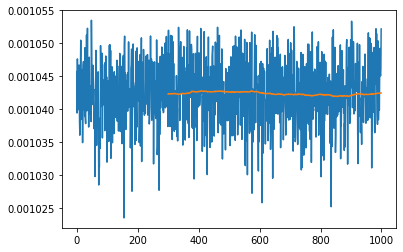

In [10]:
# validation
taus = []
for i in range(1000):
    x = np.random.randn(2,) / 16.
    a_agent, tau = a.forward(x)
    taus.append(tau)
    print(f'NN: {a_agent}, opt: {np.dot(K, x)}')
plt.plot(range(len(taus)), taus)
plt.plot(range(300, len(taus)), moving_average(taus, 300))
plt.show()

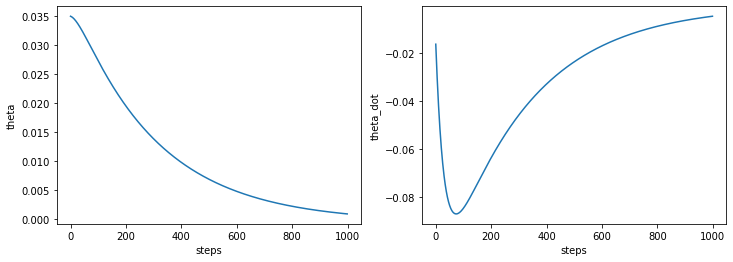

In [21]:
# 実環境テスト

def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= np.pi
    th = np.sign(th) * r
    return th

env.reset()
states = []
for i in range(1000):
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,_,_ = env.step(np.array([a_agent]), dt, tau)
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(range(states.shape[0]), states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(range(states.shape[0]), states[:,1])
plt.show()

In [23]:
print(taus)

[0.0010016633, 0.0009165574, 0.0009816183, 0.0009709386, 0.0010458471, 0.0010356935, 0.0009959912, 0.0009988481, 0.0010047326, 0.0010678514, 0.00095453026, 0.0009612866, 0.001031763, 0.000970318, 0.0009822124, 0.0010108083, 0.0009278508, 0.00096340926, 0.000992772, 0.0009879557, 0.00093832205, 0.0009548163, 0.000993264, 0.0009950384, 0.00095867447, 0.0009977643, 0.000925507, 0.0010142458, 0.0010284979, 0.0010247441, 0.0009802511, 0.0010102094, 0.00095448253, 0.0010155898, 0.0009529206, 0.0010037032, 0.0009440122, 0.0009474245, 0.0010317969, 0.0010284691, 0.001074624, 0.000995893, 0.0009497255, 0.00096287375, 0.00096967345, 0.0009935835, 0.0010573127, 0.0010394625, 0.0010048159, 0.0010230278, 0.0009863301, 0.0009934674, 0.0010211398, 0.0010869126, 0.000972078, 0.00094147294, 0.0009646212, 0.00094460155, 0.0009957621, 0.0010234261, 0.00096436054, 0.0010558959, 0.0010163002, 0.00106474, 0.0009868165, 0.0010333966, 0.0010172854, 0.0010198662, 0.00097282755, 0.0010217134, 0.001019326, 0.001

## サンプル値系の初期エージェントの学習

In [14]:
def gain(dt=None):
    m, l, g = env.m, env.l, env.g

    A = np.array([[0, 1], [(3*g)/(2*l), 0]])
    B = np.array([[0], [3/(m*l**2)]])
    Q = np.array([[1, 0], [0, 0.1]])
    R = np.array([[0.001]])
    
    if dt is not None:
        Ad, Bd = discretized_system(A, B, dt)  
        K = dlqr(Ad,Bd,Q,R)[0]
    else:
        K = lqr(A,B,Q,R)[0]
    
    return K

def model(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="multiple_tanh")(x)
    model = Model(inputs=action_input, outputs=x)
    return model

In [15]:
NN = model((1,),(2,))

In [16]:
# 学習データの用意
tau = 0.001
action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
dt = tau / action_repetition
print(dt)
K = gain(dt)
x_train = []
y_train = []
for i in range(30000):
    x_train.append([np.random.randn(2,) / 16.])
    y_train.append([np.dot(K, x_train[-1][0])])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape, y_train.shape)

0.001
(30000, 1, 2) (30000, 1)


In [17]:
# learn
NN.compile(loss='mean_squared_error',optimizer='adam')
history = NN.fit(x_train, y_train, batch_size=128, epochs=50, verbose=0)

In [18]:
# save
NN.save_weights('./saved_agent/sample_value.h5')